In [1]:
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
from timm import create_model
from fastai.vision.all import *
set_seed(999, reproducible=True)
BATCH_SIZE = 6                  
dataset_path = Path('../input/petfinder-pawpularity-score/')
dataset_path.ls()
train_df = pd.read_csv(dataset_path/'train.csv')
train_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [2]:
pth='../input/timmswin/swin_large_patch4_window12_384_22kto1k.pth'

In [3]:
os.listdir()

['__notebook__.ipynb']

In [4]:
train_df['path'] = train_df['Id'].map(lambda x:str(dataset_path/'train'/x)+'.jpg')
train_df = train_df.drop(columns=['Id'])
train_df = train_df.sample(frac=1).reset_index(drop=True)
train_df.head()

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,path
0,0,0,1,1,0,0,0,0,0,0,0,1,50,../input/petfinder-pawpularity-score/train/ebaaa8e384b3d2f0a56c7ff7675c154c.jpg
1,0,1,1,1,0,1,0,1,0,0,1,0,25,../input/petfinder-pawpularity-score/train/25e3bf4267c2dc3f579b779418221bb7.jpg
2,0,0,1,1,0,1,0,0,0,0,0,0,27,../input/petfinder-pawpularity-score/train/6548166fb3fda22b67881176397f0223.jpg
3,0,1,1,1,0,0,0,0,1,1,0,0,19,../input/petfinder-pawpularity-score/train/472c40116e1833555715e4774445ae5b.jpg
4,0,1,1,1,0,0,0,1,0,0,0,0,27,../input/petfinder-pawpularity-score/train/7b77e1a6d93667b575d57db83facd860.jpg


The mean Pawpularity score is 38.03904358353511
The median Pawpularity score is 33.0
960 960


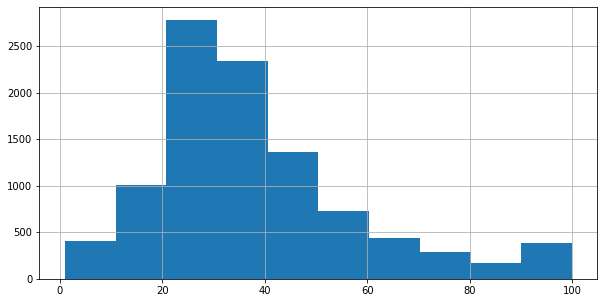

In [5]:
len_df = len(train_df)
train_df['Pawpularity'].hist(figsize = (10, 5))
print(f"The mean Pawpularity score is {train_df['Pawpularity'].mean()}")
print(f"The median Pawpularity score is {train_df['Pawpularity'].median()}")

train_df['norm_score'] = train_df['Pawpularity']/100
train_df['norm_score']
im = Image.open(train_df['path'][1])
width, height = im.size
print(width,height)

In [6]:
if not os.path.exists('/root/.cache/torch/hub/checkpoints/'):
    os.makedirs('/root/.cache/torch/hub/checkpoints/')
!cp '../input/timmswin/swin_large_patch4_window12_384_22kto1k.pth' '/root/.cache/torch/hub/checkpoints/swin_large_patch4_window12_384_22kto1k.pth'

In [7]:
seed=999
set_seed(seed, reproducible=True)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

<AxesSubplot:>

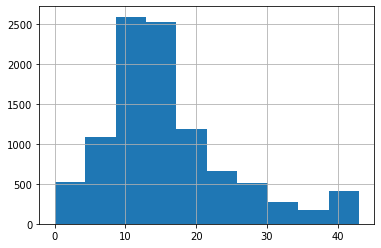

In [8]:
num_bins = int(np.floor(1+(3.3)*(np.log2(len(train_df)))))
train_df['bins'] = pd.cut(train_df['norm_score'], bins=num_bins, labels=False)
train_df['bins'].hist()

<AxesSubplot:>

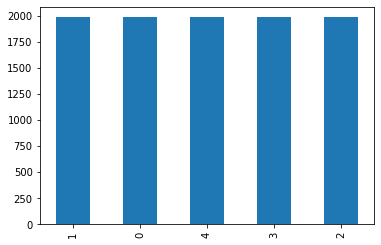

In [9]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

train_df['fold'] = -1

N_FOLDS = 5
strat_kfold = StratifiedKFold(n_splits=N_FOLDS, random_state=seed, shuffle=True)
for i, (_, train_index) in enumerate(strat_kfold.split(train_df.index, train_df['bins'])):
    train_df.iloc[train_index, -1] = i
    
train_df['fold'] = train_df['fold'].astype('int')
train_df.fold.value_counts().plot.bar()

In [10]:
train_df=pd.read_csv('../input/vision-transformer/Final_train_df.csv')

In [11]:
def petfinder_rmse(input,target):
    return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))

In [12]:
def get_data(fold):
    train_df_f = train_df.copy()
    train_df_f['is_valid'] = (train_df_f['fold'] == fold)
    dls = ImageDataLoaders.from_df(train_df_f,
                               valid_col='is_valid',
                               seed=999,
                               fn_col='path',
                               label_col='norm_score',
                               y_block=RegressionBlock,
                               bs=BATCH_SIZE, 
                               num_workers=8, 
                               item_tfms=Resize(384
                                               ), 
                               batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) 
    
    return dls

In [13]:
the_data = get_data(0)
assert (len(the_data.train) + len(the_data.valid)) == (len(train_df)//BATCH_SIZE)

In [14]:
from fastai.vision.all import *
mixup = MixUp(1.)

In [15]:
def get_learner(fold_num):
    data = get_data(fold_num)
    model = create_model('swin_large_patch4_window12_384', pretrained=True, num_classes=data.c)
    learn = Learner(data, model, loss_func=BCEWithLogitsLossFlat(),cbs=mixup,metrics=petfinder_rmse).to_fp16()
    return learn

In [16]:
test_df = pd.read_csv(dataset_path/'test.csv')
test_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
0,4128bae22183829d2b5fea10effdb0c3,1,0,1,0,0,1,1,0,0,1,0,1
1,43a2262d7738e3d420d453815151079e,0,1,0,0,0,0,1,1,0,0,0,0
2,4e429cead1848a298432a0acad014c9d,0,0,0,1,0,1,1,1,0,1,1,1
3,80bc3ccafcc51b66303c2c263aa38486,1,0,1,0,0,0,0,0,0,0,1,0
4,8f49844c382931444e68dffbe20228f4,1,1,1,0,1,1,0,1,0,1,1,0


In [17]:
test_df['Pawpularity'] = [1]*len(test_df)
test_df['path'] = test_df['Id'].map(lambda x:str(dataset_path/'test'/x)+'.jpg')
test_df = test_df.drop(columns=['Id'])


In [18]:
# get_learner(fold_num=0).lr_find(end_lr=3e-2)

In [19]:
import gc

Fold 4 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.653776,0.648928,17.317354,23:35
1,0.653782,0.641120,16.461285,23:33
2,0.646735,0.640263,16.199007,23:32
3,0.633703,0.639039,16.075731,23:33
4,0.643182,0.638492,15.962366,23:32


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6489284038543701.
Better model found at epoch 1 with valid_loss value: 0.6411197185516357.
Better model found at epoch 2 with valid_loss value: 0.6402629017829895.
Better model found at epoch 3 with valid_loss value: 0.6390390992164612.
Better model found at epoch 4 with valid_loss value: 0.6384919285774231.


Fold 5 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.654990,0.656566,18.882023,23:32
1,0.650024,0.648737,17.167345,23:32
2,0.647953,0.642308,16.541101,23:33
3,0.632798,0.643197,16.642031,23:33
4,0.636894,0.643938,16.663830,23:32


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.65656578540802.
Better model found at epoch 1 with valid_loss value: 0.6487371921539307.
Better model found at epoch 2 with valid_loss value: 0.642308235168457.
No improvement since epoch 2: early stopping


Fold 6 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.660967,0.649577,17.730389,23:33
1,0.654817,0.643671,16.718819,23:33
2,0.649817,0.645368,17.093010,23:33
3,0.637475,0.641076,16.210783,23:32
4,0.633977,0.640893,16.156635,23:34


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.649576723575592.
Better model found at epoch 1 with valid_loss value: 0.6436712145805359.
Better model found at epoch 3 with valid_loss value: 0.6410762071609497.
Better model found at epoch 4 with valid_loss value: 0.6408931612968445.


Fold 7 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.649243,0.643083,16.688105,23:33
1,0.654652,0.641033,16.583523,23:33
2,0.646217,0.639307,16.203796,23:33
3,0.642536,0.637747,16.020630,23:32
4,0.642313,0.636434,15.827528,23:34


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6430827975273132.
Better model found at epoch 1 with valid_loss value: 0.6410329341888428.
Better model found at epoch 2 with valid_loss value: 0.6393073797225952.
Better model found at epoch 3 with valid_loss value: 0.6377468109130859.
Better model found at epoch 4 with valid_loss value: 0.6364343762397766.


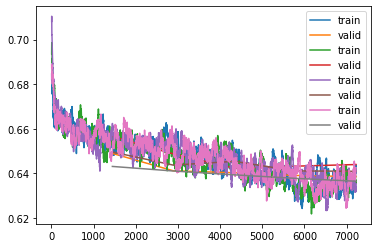

In [20]:
#3.75 *10-5

all_preds = []
for i in range(4,8):
    print(f'Fold {i} results')
    learn = get_learner(fold_num=i)
    learn.fit_one_cycle(5, 3e-05, cbs=[SaveModelCallback(), EarlyStoppingCallback(monitor='petfinder_rmse', comp=np.less, patience=2)]) 
    learn.recorder.plot_loss()
    dls = ImageDataLoaders.from_df(train_df,
                               valid_pct=0.2,
                               seed=999,  
                               fn_col='path', 
                               label_col='norm_score', 
                               y_block=RegressionBlock,
                               bs=BATCH_SIZE, 
                               num_workers=8,
                               item_tfms=Resize(384),
                               batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) 
    test_dl = dls.test_dl(test_df)
    preds, _ = learn.tta(dl=test_dl, n=5, beta=0)
    all_preds.append(preds)
    torch.save(learn.model, "model_swin_384_"+str(i)+".pt")
    del learn
    torch.cuda.empty_cache()
    gc.collect()

In [21]:
sample_df = pd.read_csv(dataset_path/'sample_submission.csv')
preds = np.mean(np.stack(all_preds), axis=0)
sample_df['Pawpularity'] = preds*100
sample_df.to_csv('submission.csv',index=False)

In [22]:
pd.read_csv('submission.csv').head()

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,40.591360
1,43a2262d7738e3d420d453815151079e,41.119785
2,4e429cead1848a298432a0acad014c9d,40.423370
3,80bc3ccafcc51b66303c2c263aa38486,40.618670
4,8f49844c382931444e68dffbe20228f4,40.317886
